# <center> How Are Ratings for UMD Professors Related to Student GPAs?</center>
CMSC320 Spring 2022 Final Project   

Andrew Zhong, James Wang, Jonah Leung

[PlanetTerp](https://planetterp.com/) is a course review website for the University of Maryland that aggregates user-submitted feedback for courses and professors at UMD. In addition to user-submitted reviews, professor and course information are retrieved from umd.io and grade data is retrieved from the UMD Office of Institutional Research, Planning & Assessment. 

Using the included [API](https://api.planetterp.com/), we retrieved course information and reviews to investigate the relationships between ratings and various factors.

## Data Collection

"Slug" is PlanetTerp's unique identifier for professors, since names may not be distinct.

### Course
Name | Type | Required | Restrictions | Description
--- | --- | --- | --- | --- |
department | string | true | none | none | 
course_number | string | true | none | none | 
title | string | true | none | none | 
description | string | true | none | none | 
credits | integer | true | none | none | 
professors | [string] | true | none | none | 
average_gpa | number | true | none | none | 

### Professor

Name | Type | Required | Restrictions | Description | 
--- | --- | --- | --- | --- | 
name | string | true | none | none | 
slug | string | true | none | none | 
type | string | true | none | none | 
courses | [string] | true | none | none | 
average_rating | number | true | none | none | 

### Grades

Name | Type | Required | Restrictions | Description | 
--- | --- | --- | --- | --- | 
course | string | true | none | none | 
professor | string | true | none | none | 
semester | string | true | none | none | 
section | string | true | none | none | 
A+ | integer | true | none | none | 
A | integer | true | none | none | 
A- | integer | true | none | none | 
B+ | integer | true | none | none | 
B | integer | true | none | none | 
B- | integer | true | none | none | 
C+ | integer | true | none | none | 
C | integer | true | none | none | 
C- | integer | true | none | none | 
D+ | integer | true | none | none | 
D | integer | true | none | none | 
D- | integer | true | none | none | 
F | integer | true | none | none | 
W | integer | true | none | none | 
Other | integer | true | none | none | 

Installing and importing required libraries, as well as defining some constants:

In [1]:
try:
  import pandas as pd
  import numpy as np
  import requests
  import matplotlib.pyplot as plt
except:
  !pip install pandas numpy requests matplotlib
  import pandas as pd
  import numpy as np
  import requests
  import matplotlib.pyplot as plt

api_url = 'https://api.planetterp.com/v1'
min_reviews = 5

We use the requests module to create HTTP GET requests in order to retrieve data from the PlanetTerp API
Retrieving reviews and reformatting the request as a Pandas dataframe:

In [2]:
# get courses
offset = 0
df_courses = pd.DataFrame()
while (True):
    response = requests.get(api_url + "/courses?&reviews=true&limit=1000&offset=" + str(offset))
    courses = response.json()
    if (len(courses) == 0):
        break
    df_courses = pd.concat([df_courses, pd.DataFrame(courses)], ignore_index=True)
    offset += 1000

# filter only courses with a minimum number of reviews
df_courses["review_count"] = df_courses["reviews"].apply(lambda x: len(x))
df_courses = df_courses[df_courses["review_count"] >= min_reviews]
df_courses = df_courses.replace(r'(\r\n)|\r|\n',' ', regex=True) # remove newlines
df_courses = df_courses.replace("\"", "", regex=True) # remove quotes


offset = 0
df_profs = pd.DataFrame()
while (True):
    response = requests.get(api_url + "/professors?type=professor&reviews=true&limit=1000&offset=" + str(offset))
    professors = response.json()
    if (response.status_code != 200 or len(professors) == 0):
        break
    df_profs = pd.concat([df_profs, pd.DataFrame(professors)], ignore_index=True)
    offset += 1000

# filter only professors with a minimum number of reviews
df_profs["review_count"] = df_profs["reviews"].apply(lambda x: len(x))
df_profs = df_profs[df_profs["review_count"] >= min_reviews]
df_courses = df_courses.replace(r'(\r\n)|\r|\n',' ', regex=True) # remove newlines
df_profs = df_profs.replace("\"", "", regex=True) # remove quotes


df_grades_full = pd.DataFrame()
for p in df_profs["name"]:
    response = requests.get(api_url + "/grades?professor=" + p)
    grades = response.json()
    if (response.status_code != 200):
        break
    df_grades_full = pd.concat([df_grades_full, pd.DataFrame(grades)], ignore_index=True)


print("loaded " + str(len(df_profs)) + " professors and " + str(len(df_courses)) + " courses")

loaded 867 professors and 570 courses


It's difficult to make a judgement on professors with very few reviews. Since we had to fetch grade data one at a time by professor, we already filtered out all professors with less reviws under a minimum threshold from the dataframe and used those to fetch grades. We went with with 5, and change it if necessary.

We've created a 'reviews_count' column for both the professors and courses dataframes for convenience and later analysis. Now lets look at the three dataframes we've created from the PlanetTerp API.

# Exploring the Dataset

In [3]:
df_courses.head(3)

,department,course_number,title,description,credits,professors,average_gpa,reviews,review_count
1,AASP,100,Introduction to African American Studies,Significant aspects of the history of African ...,3.0,"[Jason Nichols, Jonathan England, Shane Walsh,...",3.21722,"[{'professor': 'Jonathan England', 'course': '...",29
2,AASP,100H,Introduction to African American Studies,Significant aspects of the history of African ...,3.0,"[Jonathan England, Shane Walsh, George Kintiba...",3.16167,"[{'professor': 'Jonathan England', 'course': '...",5
3,AASP,101,Public Policy and the Black Community,<b>Formerly:</b> AASP300. The impact of public...,3.0,"[Jonathan England, Gniesha Dinwiddie, Alana Ha...",3.22089,"[{'professor': 'Jonathan England', 'course': '...",7


In [4]:
df_profs.head(3)

,name,slug,type,courses,reviews,average_rating,review_count
3,A Sharma,sharma_a,professor,[ASTR300],"[{'professor': 'A Sharma', 'course': 'ASTR300'...",1.80,5
5,A.U. Shankar,shankar_a.u.,professor,"[CMSC412, CMSC414, CMSC712, CMSC216, CMSC798]","[{'professor': 'A.U. Shankar', 'course': 'CMSC...",2.44,25
26,Aaron Swanlek,swanlek,professor,[COMM107],"[{'professor': 'Aaron Swanlek', 'course': 'COM...",5.00,9


In [5]:
df_grades_full.head(3)

,course,professor,semester,section,A+,A,A-,B+,B,B-,C+,C,C-,D+,D,D-,F,W,Other
0,ASTR300,A Sharma,201901,0101,0,8,5,5,16,5,4,8,4,0,2,0,0,3,1
1,ASTR300,A Sharma,201808,0101,0,3,6,4,11,5,4,10,2,0,0,0,2,4,2
2,ASTR300,A Sharma,201801,0101,0,14,15,10,9,2,2,1,2,2,1,0,0,0,0


Currently, the grades dataframe has a separate row for each course, professor, and semester, and section combination. For our purposes, we will not need to worry about differentiating separate semesters, and especially section. We combine the rows with the same course and professor, summing up the counts for letter grades. We also create a "total" column that sums up how many letter grades are in each row and a "credits" column with each course's credits obtained from df_courses. We then combine the rows again if they share a professor, to have a dataframe the contains a row for each professor. GPA is another metric we will look at, so we create this column too.

In [6]:
letter_grades = ["A+","A","A-","B+","B","B-","C+","C","C-","D+","D","D-","F"]
letter_weights = [4.0,4.0,3.7,3.3,3.0,2.7,2.3,2.0,1.7,1.3,1.0,0.7,0.0]
credits_lookup = {}
for i in range(len(df_courses)):
    credits_lookup[df_courses.iloc[i]["department"] + df_courses.iloc[i]["course_number"]] = df_courses.iloc[i]["credits"]

# filter out courses not in df_courses
df_grades = df_grades_full[df_grades_full["course"].isin(credits_lookup)]

# create column for total number of letter grades
df_grades["total"] = df_grades[letter_grades].sum(axis=1)
# combine rows with same course and professor
df_grades = df_grades[["course", "professor"] + letter_grades + ["W", "Other", "total"]].groupby(["course", "professor"]).sum().reset_index()


# change NaN to 0 in "credits" column and type to int
df_courses["credits"] = df_courses["credits"].fillna(0).astype(int)
# create "credits" column in df_grades from "credits" column in df_courses
df_grades["credits"] = df_grades["course"].map(credits_lookup)
# combine rows with same professor
df_grades_profs = df_grades.groupby(["professor"]).sum().reset_index()
# calculate GPA
df_grades_profs["GPA"] = df_grades[letter_grades].apply(lambda letters: np.dot(letters.values, letter_weights), axis=1) / df_grades["total"]

df_grades_profs.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,professor,A+,A,A-,B+,B,B-,C+,C,C-,D+,D,D-,F,W,Other,total,credits,GPA
0,A Sharma,1,34,37,42,67,28,13,26,12,4,4,1,3,13,4,272,3.0,3.760000
1,A.U. Shankar,58,112,76,77,154,67,60,113,72,0,54,1,78,93,135,922,11.0,3.161107
2,Aaron Swanlek,272,65,24,10,1,4,1,1,0,0,0,0,1,4,1,379,3.0,3.130192
3,Abram Kagan,0,54,17,0,36,11,0,25,9,0,1,0,5,18,3,158,6.0,3.940000
4,Adam Hsieh,13,112,73,72,63,70,39,17,24,4,2,0,4,12,0,493,6.0,3.718750


We can now combine this dataframe with df_profs, since they both just have one row per professor.

In [7]:
# join df_grades_profs with df_profs
print(len(df_grades_profs), len(df_profs))

df_profs2 = pd.merge(df_profs, df_grades_profs.rename(columns={"professor":"name"}), on="name")
df_profs2 = df_profs2.drop(columns=["slug", "type", "courses", "reviews"])
df_profs2.head()

779 867


,name,average_rating,review_count,A+,A,A-,B+,B,B-,C+,...,C-,D+,D,D-,F,W,Other,total,credits,GPA
0,A Sharma,1.8000,5,1,34,37,42,67,28,13,...,12,4,4,1,3,13,4,272,3.0,3.760000
1,A.U. Shankar,2.4400,25,58,112,76,77,154,67,60,...,72,0,54,1,78,93,135,922,11.0,3.161107
2,Aaron Swanlek,5.0000,9,272,65,24,10,1,4,1,...,0,0,0,0,1,4,1,379,3.0,3.130192
3,Abram Kagan,2.7000,10,0,54,17,0,36,11,0,...,9,0,1,0,5,18,3,158,6.0,3.940000
4,Adam Hsieh,3.8889,9,13,112,73,72,63,70,39,...,24,4,2,0,4,12,0,493,6.0,3.718750


In [8]:
df3 = df_courses.dropna()
df3['title+course_number'] = df3['course_number'].astype(str) +"-"+ df3["title"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
len(pd.unique(df3['title+course_number']))

553

In [10]:
df3[df3.duplicated(['title+course_number'], keep=False)]

,department,course_number,title,description,credits,professors,average_gpa,reviews,review_count,title+course_number
4109,CMSC,456,Cryptography,"<b>Prerequisite:</b> (CMSC106, CMSC131, or ENE...",3,"[Jonathan Katz, James Schafer, Lawrence Washin...",2.36667,"[{'professor': 'Jonathan Katz', 'course': 'CMS...",21,456-Cryptography
6199,ENAE,202,Computing Fundamentals for Engineers,<b>Corequisite:</b> Must be concurrently enrol...,3,"[Robert Sanner, Johan Larsson, Abhijit Dasgupt...",2.81918,"[{'professor': 'Robert Sanner', 'course': 'ENA...",18,202-Computing Fundamentals for Engineers
7573,ENME,202,Computing Fundamentals for Engineers,<b>Corequisite:</b> Must be concurrently enrol...,3,"[Johan Larsson, Robert Sanner, Don DeVoe, Abhi...",2.90437,"[{'professor': 'Johan Larsson', 'course': 'ENM...",7,202-Computing Fundamentals for Engineers
12757,MATH,456,Cryptography,"<b>Prerequisite:</b> (CMSC106, CMSC131, or ENE...",3,"[James Schafer, Lawrence Washington, Jonathan ...",2.99110,"[{'professor': 'Lawrence Washington', 'course'...",6,456-Cryptography
17290,WGSS,250,Introduction to WGSS: Art and Culture,<b>Credit only granted for:</b> WMST250 or WGS...,3,"[Taylor York, Kate Yanchulis, Sarah Scriven, M...",3.68652,"[{'professor': 'Sina Lee', 'course': 'WGSS250'...",6,250-Introduction to WGSS: Art and Culture
17332,WMST,250,Introduction to WGSS: Art and Culture,<b>Credit only granted for:</b> WMST250 or WGS...,3,"[Katie King, Renina Jarmon, Catherine Schuler,...",3.52552,"[{'professor': 'Deborah Rosenfelt', 'course': ...",20,250-Introduction to WGSS: Art and Culture


We see that, upon organizing our data by course number and name, that there are repeats! The repeated classes are those that cross lines between different academic disciplines, but since they are technically two different classes, we decided to keep them in the dataset instead of removing the duplicates.

# Visualizations
First we create a couple of visualizations to get a better grasp on our dataset.

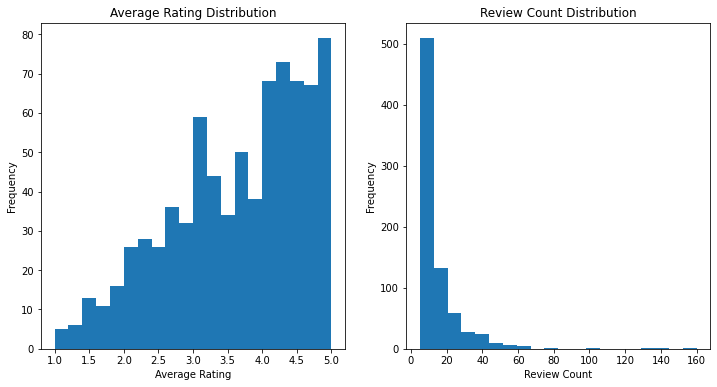

In [11]:
# create two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# plot distribution average rating
ax1.hist(df_profs2["average_rating"], bins=20)
ax1.set_title("Average Rating Distribution")
ax1.set_xlabel("Average Rating")
ax1.set_ylabel("Frequency")

# plot distribution of review count
ax2.hist(df_profs2["review_count"], bins=20)
ax2.set_title("Review Count Distribution")
ax2.set_xlabel("Review Count")
ax2.set_ylabel("Frequency")

# show the plots
plt.show()

We see that there are much much more higher ratings (towards 5) than lower raitngs (towards 1). This might mean students are more likely to leave a rating if it's good than bad, or maybe our professors are just really good at teaching. We also see that a high majority of professors tend to have between 5-10 reviews (after removing professors with under 5 reviews).

## Best Professors

The most straightforward approach we could take to figuring out the best professor is just sorting by ratings.

In [12]:
# sort professors by rating
df_profs2.sort_values(by=["average_rating"], ascending=False).head(10)

,name,average_rating,review_count,A+,A,A-,B+,B,B-,C+,...,C-,D+,D,D-,F,W,Other,total,credits,GPA
73,Ashley Aragon,5.0,7,100,38,16,4,5,2,1,...,0,0,1,1,1,2,0,170,3.0,2.905336
229,Eric Luedtke,5.0,7,193,153,74,43,22,9,6,...,3,0,0,2,10,14,6,523,6.0,3.048000
107,Caroline Rothrock,5.0,8,16,48,21,3,5,2,4,...,0,0,1,0,2,5,5,104,9.0,3.057078
105,Carmen Cantemir-Stone,5.0,7,76,155,69,48,85,21,18,...,12,3,3,1,4,20,2,516,4.0,2.875647
33,Amanda Hall,5.0,6,310,94,50,5,7,4,3,...,1,0,0,0,2,12,0,481,3.0,2.920877
68,Aric Bills,5.0,8,104,157,73,36,52,39,27,...,12,10,3,2,19,31,54,551,6.0,3.937975
36,Amelia Branigan,5.0,7,185,235,91,27,25,15,9,...,2,5,6,0,8,23,19,616,3.0,3.971111
98,Bruce Jacob,5.0,7,48,68,36,25,12,1,5,...,3,0,2,0,2,9,0,209,5.0,3.085714
40,Amr Baz,5.0,11,39,397,55,83,154,17,25,...,16,0,1,0,3,11,20,829,9.0,3.770445
41,Amy Fisher,5.0,5,393,606,150,47,26,11,7,...,0,1,2,0,3,20,4,1249,3.0,3.394172


Unsurprisingly, we see most all of the top 10 being  professors with a relatively small number of reviews. These professors might just not had enough reviews written for them to get their first non 5-star review. One approach to counteract this is using a Bayesian average, which is used to estimate the real average by using outside information. We can introduce "dummy reviews" to all of the professors with the average rating among all professors, and recalculate the average. The Bayesian average for all professors will be slightly closer to the average rating, but impacts professors with a high review count much less than one with a low review count. We can try adding one dummy review first.

In [13]:
# average rating median
avg = df_profs2["average_rating"].median()
print("Median average rating: " + str(avg))

# add a dummy reviews with the average rating and get the new average rating
df_profs2["bayesian_avg"] = (df_profs2["average_rating"] * df_profs2["review_count"] + avg) / (df_profs2["review_count"] + 1)
df_profs2.sort_values(by=["bayesian_avg"], ascending=False).head(10)

Median average rating: 3.8182


,name,average_rating,review_count,A+,A,A-,B+,B,B-,C+,...,D+,D,D-,F,W,Other,total,credits,GPA,bayesian_avg
495,Michael Galczynski,4.9773,44,225,686,143,137,122,28,27,...,1,5,0,18,29,44,1420,15.0,2.722556,4.951542
255,George Kurtzweil,5.0000,14,62,340,57,24,10,3,0,...,0,0,0,0,9,7,496,3.0,3.118868,4.921213
164,David Brookshire,5.0000,14,46,638,280,120,77,44,8,...,1,0,0,34,28,27,1269,6.0,3.144845,4.921213
679,Stefan Doboszczak,4.9565,23,118,241,176,132,139,100,55,...,25,28,9,43,70,162,1150,28.0,3.267708,4.909071
40,Amr Baz,5.0000,11,39,397,55,83,154,17,25,...,0,1,0,3,11,20,829,9.0,3.770445,4.901517
386,Justin Wyss-Gallifent,4.9063,160,4362,3178,1041,555,1290,507,248,...,46,200,46,289,658,187,12562,33.0,3.229819,4.899542
49,Andrew Schonebaum,5.0000,10,0,239,61,34,28,12,4,...,0,0,0,4,8,23,385,3.0,3.523684,4.892564
720,Thomas Murphy,5.0000,10,35,147,75,59,112,69,32,...,8,20,9,22,52,49,675,4.0,3.423358,4.892564
653,Samuel Handwerger,5.0000,10,25,354,319,301,289,105,32,...,0,2,0,3,20,40,1454,24.0,3.130000,4.892564
646,Ryan Smith,5.0000,10,94,101,41,32,20,10,4,...,0,1,1,7,14,13,319,2.0,1.955738,4.892564


We see that half the professors in this top ten has 10 or 11 total reviews, which still seems too little to be ranked this high. What happens if we add two reviews?

In [14]:
df_profs2["bayesian_avg"] = (df_profs2["average_rating"] * df_profs2["review_count"] + avg * 2) / (df_profs2["review_count"] + 2)
df_profs2.sort_values(by=["bayesian_avg"], ascending=False).head(10)

,name,average_rating,review_count,A+,A,A-,B+,B,B-,C+,...,D+,D,D-,F,W,Other,total,credits,GPA,bayesian_avg
495,Michael Galczynski,4.9773,44,225,686,143,137,122,28,27,...,1,5,0,18,29,44,1420,15.0,2.722556,4.926904
386,Justin Wyss-Gallifent,4.9063,160,4362,3178,1041,555,1290,507,248,...,46,200,46,289,658,187,12562,33.0,3.229819,4.892867
679,Stefan Doboszczak,4.9565,23,118,241,176,132,139,100,55,...,25,28,9,43,70,162,1150,28.0,3.267708,4.865436
164,David Brookshire,5.0000,14,46,638,280,120,77,44,8,...,1,0,0,34,28,27,1269,6.0,3.144845,4.852275
255,George Kurtzweil,5.0000,14,62,340,57,24,10,3,0,...,0,0,0,0,9,7,496,3.0,3.118868,4.852275
40,Amr Baz,5.0000,11,39,397,55,83,154,17,25,...,0,1,0,3,11,20,829,9.0,3.770445,4.818185
370,Jose Calderon,4.8846,26,246,134,137,108,106,84,68,...,11,12,9,16,62,43,1007,10.0,3.236333,4.808429
646,Ryan Smith,5.0000,10,94,101,41,32,20,10,4,...,0,1,1,7,14,13,319,2.0,1.955738,4.803033
653,Samuel Handwerger,5.0000,10,25,354,319,301,289,105,32,...,0,2,0,3,20,40,1454,24.0,3.130000,4.803033
720,Thomas Murphy,5.0000,10,35,147,75,59,112,69,32,...,8,20,9,22,52,49,675,4.0,3.423358,4.803033


We start to see more professors with a higher review count, which more closely matches our intuition for picking the best professors.

To see what might cause the average rating to be higher, we can create visualizations to see if any patterns arise or we can find predictors of average ratings. Here we will look at credits and GPA. Before creating the visualizations, we first might speculate that higher credit counts would also bring higher average ratings, having more teaching experience. For GPA, maybe a higher GPA might make the professor more well-liked and rated higher. Let's see if this holds in the actual data.

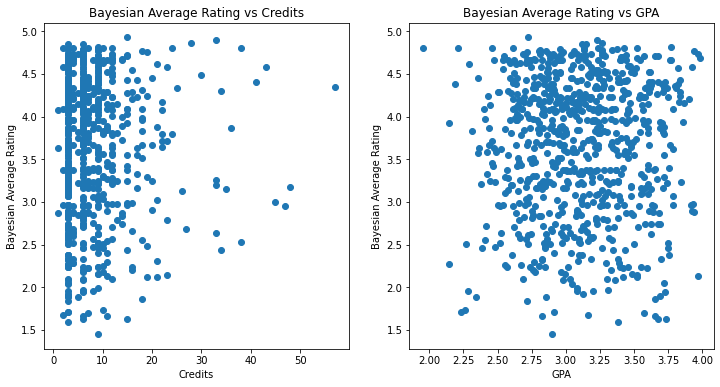

In [15]:
# create two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
# plot bayesian average vs credits
ax1.scatter(df_profs2["credits"], df_profs2["bayesian_avg"])
ax1.set_title("Bayesian Average Rating vs Credits")
ax1.set_xlabel("Credits")
ax1.set_ylabel("Bayesian Average Rating")

# plot bayesian average vs GPA
ax2.scatter(df_profs2["GPA"], df_profs2["bayesian_avg"])
ax2.set_title("Bayesian Average Rating vs GPA")
ax2.set_xlabel("GPA")
ax2.set_ylabel("Bayesian Average Rating")

# show
plt.show()

In the first scatterplot, we see that are a few vertical lines with a higher concetrated areas of dots. It's important to reflect on why certain patterns might occur. For this case, it's just because most courses are offered as 3 credits, so we naturally see most professors teach some multiple of 3 credits. We also see that the lowest average rating begins to drop as professors teach more and more credits. You could speculate that the professors who have taught a wide variety of classes in general have more teaching experience, in terms of both time and diversity. They also can mean they enjoy teaching more, spending more effort on their courses. This pattern only applies to the lowest average ratings; there is no significant correlation between rating and credits overall.

Turning our attention to second scatterplot with GPA, we don't really see any patterns here. It seems like students aren't just giving ratings depending on how easy the class is.

Let's try to visualize a comparison between Rating and GPA:

In [16]:
avg_course_ratings = []
for course in df_courses['reviews']:
    s, n = 0, 0
    for review in course:
        s += review['rating']
        n += 1
    avg_course_ratings.append(s/n)
avg_course_ratings = np.array(avg_course_ratings)
avg_course_ratings = [i for i in avg_course_ratings if i != '']

print(f"Mean course rating: {np.mean(avg_course_ratings)}")

Mean course rating: 3.6939187101124844


In [17]:
avg_gpa = []
for temp in df_courses['average_gpa']:
    avg_gpa.append(temp)
print(avg_gpa)

[3.21722, 3.16167, 3.22089, 3.36021, 3.0099, 2.3, 3.88683, 3.17934, 2.94044, 2.97769, 2.80508, 3.25633, 3.2892, 3.31727, 2.55084, 3.80413, 2.08828, 3.22133, 3.08097, 3.22068, 3.5092, 3.6453, 3.29092, 3.22608, 3.05917, 2.90788, 2.83879, 3.05106, 3.0352, 2.80633, 2.87275, 3.38591, 2.80397, 2.79082, 2.74171, 2.99226, 2.8668, 3.22866, 3.32131, 3.09562, 3.37301, 3.57728, 2.68909, 2.88717, 2.71959, 3.28993, 2.81883, 2.82124, 2.8319, 3.22204, 2.64992, 2.70687, 2.59563, 2.79611, 2.99779, 3.10019, 3.38684, 2.92027, 2.75663, 3.1657, 3.20668, 3.13975, 3.59747, 3.59422, 2.91772, 3.27377, 3.22261, 2.40444, 2.86114, 2.54952, 2.89627, 3.20362, 3.48693, 3.35817, 3.50391, 3.222, 3.17204, 3.26074, 2.79581, 2.89603, 3.25493, 3.41524, 2.99083, 3.32254, 3.42387, 2.89004, 2.92098, 3.35948, 3.22763, 3.46887, 3.13921, 3.38309, 3.45194, 3.51988, 3.39048, 3.22435, 2.92802, 3.41047, 3.23695, 2.88656, 3.87607, 3.32094, 3.50649, 3.62264, 3.31806, 3.17086, 2.97521, 3.36989, 3.48206, 3.62686, 3.50855, 3.3908, 3.3969

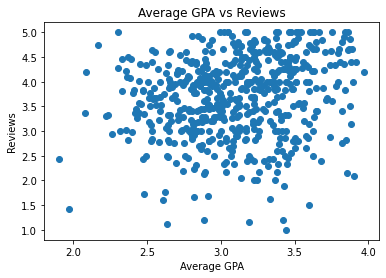

In [18]:
import matplotlib.pyplot as plt
plt.scatter(avg_gpa, avg_course_ratings, label='Scatter Plot')
plt.xlabel('Average GPA')
plt.ylabel('Reviews')
plt.title('Average GPA vs Reviews')
plt.show()  

Now that we have a visualization, we can try to further enhance it with a regression model



> Since we do have nan values in avg_gpa, but each gpa corresponds to a rating, we make a temporary numpy array with the NaN values taken out and use that for calculating the regression, but still plot the original avg_gpa graph


In [19]:
avg_gpas = np.array(avg_gpa)
avg_gpas = avg_gpas[np.logical_not(np.isnan(avg_gpas))]

Now make the proper calculations for linear regression

In [20]:
import math
mean_x = np.nanmean(avg_gpa)
mean_y = np.mean(avg_course_ratings)
#Using the formula to calculate b1 and b0
numer = 0
denom = 0
for i in range(len(avg_gpa)):
  if math.isnan(avg_gpa[i]) == False:
    numer += (avg_gpa[i] - mean_x) * (avg_course_ratings[i] - mean_y)
    denom += (avg_gpa[i] - mean_x) ** 2
b1 = numer/denom
b0 = mean_y - (b1* mean_x)

max_x = np.max(avg_gpas)
min_x = np.min(avg_gpas)
max_y = np.max(avg_course_ratings)

#Calculating line values x and y
x = np.linspace(min_x, max_x)
y = b0 + b1 * x

Lastly, plot!

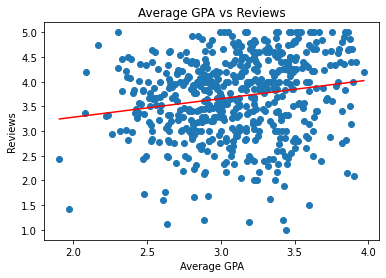

In [21]:
plt.scatter(avg_gpa, avg_course_ratings, label='Scatter Plot')
plt.plot(x,y, color='red', label='Regression Line')
plt.xlabel('Average GPA')
plt.ylabel('Reviews')
plt.title('Average GPA vs Reviews')
plt.show()

As a followup, let's try to measure the accuracy 

In [22]:
#Using R-Squared
ss_t = 0
ss_r = 0
for i in range(len(avg_gpa)):
  if math.isnan(avg_gpa[i]) == False:
    y_pred = b0 + b1 * avg_gpa[i]
    ss_t += (avg_course_ratings[i] - mean_y) ** 2
    ss_r += (avg_course_ratings[i] - y_pred) ** 2
r2 = 1 - (ss_r/ss_t)
#print(ss_r/ss_t)
print(r2)

0.03242201029758518


While this value isn't as close to 1 as many would like, the fact that our value comes out to >0 is acceptable, especially considering the clumped nature of the graph.



Let's try to see if we get a clearer trend when we split courses into departments. Since there are so many unique departments, let's just look at the ones that we care about for now :).

In [23]:
len(pd.unique(df_courses['department']))

86

In [24]:
targets = ['CMSC', 'MATH', 'ENGL', 'BMGT', 'HACS', 'ENES', 'BCHM']

data_per_class = []
for dep in targets:
  data_per_class.append(df3[df3['department'] == dep])

# How Do Ratings Change Over Time?

A well-known phenomenon in education systems is grade inflation, where average grades increase over time and give the appearance of overall academic improvement. It may be possible that professor ratings follow the same or even opposite behavior. Especially given the dramatic changes in class format due to the COVID-19 pandemic, remote learning, and the resulting reformatting, we'd like to know if class quality or the perception of quality has changed in recent years. To investigate how ratings change over time, we define the function plot_per_year which collects ratings from a given dataframe into buckets by year and displays them.

In [25]:
import datetime
from dateutil.parser import isoparse
def plot_per_year(df, title="Average Ratings by Year"):

    # Put ratings into buckets by year
    reviews_by_year = {}
    for course in df['reviews']:
        for review in course:
            utc = isoparse(review['created'])
            if utc.year not in reviews_by_year:
                reviews_by_year[utc.year] = []
            reviews_by_year[utc.year].append(review['rating'])
    years = sorted(list(reviews_by_year.keys()))
    
    # Line plot of change in average rating over time
    plt.ylim(0, 5)
    plt.plot(years, [np.mean(reviews_by_year[year]) for year in years])
    plt.xlabel("Year")
    plt.ylabel("Average Rating")
    plt.title(title)
    plt.show()

Let's see how the average across all professors and courses has changed over time. We can see that there haven't been any dramatic changes in rating over time and that the COVID-19 pandemic has produced unremarkable changes in rating from the years 2019-2022. Since we can't see any campus-wide trends, we'll have to look at individual professors and departments to see if we can observe something more specific.

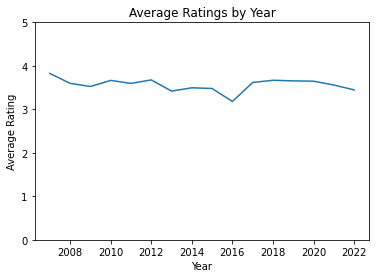

In [26]:
plot_per_year(df_profs)

Since many professors only have ratings from a shorter period of time, let's look at the most reviewed professors so that we can have a larger timeframe. We'll look at Justin, Herman, and Professor Dixon (since that's the highest non CMSC or MATH professor).

In [27]:
df_profs.sort_values('review_count', ascending=False)

,name,slug,type,courses,reviews,average_rating,review_count
5340,Justin Wyss-Gallifent,wyss-gallifent,professor,"[MATH206, MATH241, MATH410, MATH695, HONR219O,...","[{'professor': 'Justin Wyss-Gallifent', 'cours...",4.9063,160
6036,Larry Herman,herman_laurence,professor,"[CMSC102, CMSC216, CMSC132, CMSC330, CMSC132H]","[{'professor': 'Larry Herman', 'course': 'CMSC...",2.9565,138
1206,Bonnie Dixon,dixon_bonnie,professor,"[CHEM135, CHEM231, HONR288B, BCHM463, CHEM241,...","[{'professor': 'Bonnie Dixon', 'course': 'CHEM...",3.8750,136
7801,Nelson Padua-Perez,padua-perez,professor,"[CMSC132, CMSC106, CMSC216, INFM743, CMSC132H,...","[{'professor': 'Nelson Padua-Perez', 'course':...",4.0857,105
3329,Fawzi Emad,emad_fawzi,professor,"[CMSC122, CMSC131, CMSC132, CMSC131H, CMSC250]","[{'professor': 'Fawzi Emad', 'course': 'CMSC13...",4.4412,102
...,...,...,...,...,...,...,...
2615,Derrick Yeo,yeo_derrick,professor,"[FIRE120, FIRE164, FIRE264, FIRE198, FIRE298, ...","[{'professor': 'Derrick Yeo', 'course': 'FIRE1...",5.0000,5
9556,Silvina Matysiak,matysiak,professor,"[BIOE689D, BIOE331, BIOE232, BIOE601, BIOE489N...","[{'professor': 'Silvina Matysiak', 'course': '...",3.2000,5
9560,Simon Sheaff,sheaff,professor,[GVPT170],"[{'professor': 'Simon Sheaff', 'course': 'GVPT...",5.0000,5
9580,Sofia Maurette,maurette,professor,"[SPAN103, SPAN207, SPAN301, SPAN204, SPAN203, ...","[{'professor': 'Sofia Maurette', 'course': 'SP...",1.6000,5


It looks like everyone has always loved Justin - the ratings are so high that you can barely distinguish the line from the upper border of the plot.

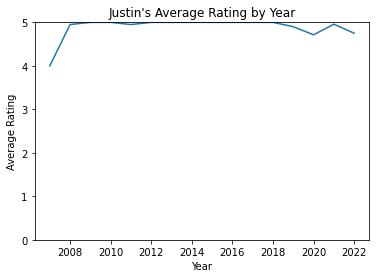

In [28]:
plot_per_year(df_profs[df_profs['slug'] == 'wyss-gallifent'], title="Justin's Average Rating by Year")

Professor Dixon also enjoyed high ratings, but they plummeted in 2019 indicating that for whatever reason, her courses did not translate well to the pandemic. 

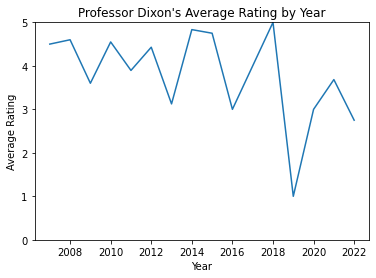

In [29]:
plot_per_year(df_profs[df_profs['slug'] == 'dixon_bonnie'], title="Professor Dixon's Average Rating by Year")

Herman's ratings have fluctuated between 2 and 4, with all of the highest rated years being in the 2010s.